In [ ]:
'''
Author: Conor Lane, February 2024
Contact: conor.lane1995@gmail.com

Analysis code for calculating sensitivity of both all individual cells, and changes in sensitivity between pre- and post- for the randomized stim cohort. 
Sensitivity = the lowest intensity at which a cell shows a significant response to sound-stimulation. 

INPUTS: filepath to the evoked cohort megadicts (collected recordings for each condition from Evoked Cohort)
        z_thresh - minimum z-score threshold over which we declare a significant response (default is 4).
'''

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.metrics import pairwise_distances
import pandas as pd
import scipy.stats as ss
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import kstest
import os
from collections import Counter

z_thresh = 4
filepath = "F:/Two-Photon/Psilocybin Project/Evoked Cohort Mice/megadicts"

LOAD RANDOMIZED STIM COHORT DICTS:

In [2]:
# Dictionary to map filenames to variable names
file_variable_mapping = {
    'saline_pre_dict.pkl': 'saline_pre',
    'saline_post_dict.pkl': 'saline_post',
    'psilo_pre_dict.pkl': 'psilo_pre',
    'psilo_post_dict.pkl': 'psilo_post'
}

# Initialize empty dictionaries
saline_pre = {}
saline_post = {}
psilo_pre = {}
psilo_post = {}

# Iterate through files in megadict folder
for filename in os.listdir(filepath):
    if filename in file_variable_mapping:
        file_path = os.path.join(filepath, filename)
        with open(file_path, 'rb') as file:
            # Load pkl file and assign to respective dictionary variable
            globals()[file_variable_mapping[filename]] = pickle.load(file)

GENERAL FUNCTIONS:

In [3]:
# Plots a double-bar graph for two chosen sensitivity arrays. 
# INPUTS: values_set_1 and 2 - the two sets of sensitivities to compare
#         title - title of graph as string
#         label_1 - first bar label e.g. Pre-Saline
#         label_2 - second bar label

def calculate_relative_frequencies(values, unique_values):
    total_values = len(values)
    frequencies = np.array([np.sum(values == value) / total_values for value in unique_values])
    return frequencies

def plot_comparison(values_set1, values_set2,title,label_1,label_2):
    # Calculate unique values for each set
    unique_values_set1 = np.unique(values_set1)
    unique_values_set2 = np.unique(values_set2)
    
    # Combine unique values from both sets
    unique_values = np.unique(np.concatenate((unique_values_set1, unique_values_set2)))

    # Halve the unique values except for 0
    halved_unique_values = [value / 2 if value != 0 else 0 for value in unique_values]

    # Calculate relative frequencies for each set based on the unique values
    rel_freq_set1 = calculate_relative_frequencies(values_set1, unique_values)
    rel_freq_set2 = calculate_relative_frequencies(values_set2, unique_values)

    # Set the width of the bars
    bar_width = 0.35

    # Set the positions of the bars on the x-axis
    r1 = np.arange(len(unique_values))
    r2 = [x + bar_width for x in r1]

    # Create the bar plot
    plt.bar(r1, rel_freq_set1, color='blue', width=bar_width, edgecolor='black', label=label_1)
    plt.bar(r2, rel_freq_set2, color='orange', width=bar_width, edgecolor='black', label=label_2)

    # Add labels and title
    plt.xlabel('Bandwidth (Octaves)')
    plt.ylabel('Probability')
    plt.title(title)

    # Set the modified x tick labels
    plt.xticks([r + bar_width / 2 for r in range(len(unique_values))], halved_unique_values)

    # Add legend
    plt.legend()
    plt.tight_layout()

    # Show plot
    plt.show()

In [4]:
# Create an array of all the matched cells that are sound-responsive in both recordings.  Each row is a matched cell pair. 
# INPUTS:  pre- and post- megadicts for a given drug condition. 
#          The specific recording to get matched cells for in the sub-dictionaries of pre- and post.
#          Code is written to be used with the matched cells bandwidth functions. 
# OUTPUTS: (npairs x 2) array containing the matched cell pairs that were responsive in both recordings. 

def get_consistently_responsive_cells(dict_pre,dict_post,sub_dict_pre,sub_dict_post):

    matched_responsive_1 = []
    matched_responsive_2 = []

    # Get the array of matched cell pairs stored under the dictionary's first cell key. 
    matched_cells = dict_post[sub_dict_post][next(iter(dict_post[sub_dict_post]))]['matched_cells']

    # iterate through each cell in the first dict and check if it is a matched cell pair.  Append the matched cells to a list.
    for cell in dict_pre[sub_dict_pre]:
            if cell in matched_cells[:,0] and dict_pre[sub_dict_pre][cell]['active'] == True:
                matched_responsive_1.append(cell)

    # Same operation but with the second dictionary.
    for cell in dict_post[sub_dict_post]:
            if cell in matched_cells[:,1] and dict_post[sub_dict_post][cell]['active'] == True:
                matched_responsive_2.append(cell)

    indices = np.where(np.isin(matched_cells[:, 0], matched_responsive_1))

    # Find the indices where the values in column 0 appear in the first match list.
    indices_col1 = np.isin(matched_cells[:, 0], matched_responsive_1)

    # Find the indices where the values in column 1 appear in the second match list. 
    indices_col2 = np.isin(matched_cells[:, 1], matched_responsive_2)

    # Combine the two conditions using logical AND
    combined_indices = np.logical_and(indices_col1, indices_col2)

    # Extract the rows where both conditions are true
    coactive = matched_cells[combined_indices]

    return coactive


In [5]:
def calculate_cdf(data):
    # Define your series
    s = pd.Series(data, name = 'value')
    df = pd.DataFrame(s)
    # Get the frequency, PDF and CDF for each value in the series

    # Frequency
    stats_df = df \
    .groupby('value') \
    ['value'] \
    .agg('count') \
    .pipe(pd.DataFrame) \
    .rename(columns = {'value': 'frequency'})

    # PDF
    stats_df['pdf'] = stats_df['frequency'] / sum(stats_df['frequency'])

    # CDF
    stats_df['cdf'] = stats_df['pdf'].cumsum()
    stats_df = stats_df.reset_index()
    stats_df

    return stats_df

In [6]:
def plot_cdf(pre,post,title,label_1,label_2):
    pre_cdf = calculate_cdf(pre)
    post_cdf = calculate_cdf(post)

    label = [label_1,label_2]

    zipped = zip([pre_cdf,post_cdf], label)

    fig = plt.figure()

    for frame,label in zipped:
        plt.plot(frame['value'], frame['cdf'],label = label )
    plt.title(title,pad=10)
    plt.xticks(range(4), [35,50,65,80],fontsize=14)
    plt.xlabel("Lowest Response Intensity (dB)",fontsize=14,labelpad=10)
    plt.ylabel("Cumulative Probability",fontsize=14,labelpad=10)
    plt.yticks(fontsize=14)
    plt.grid(alpha=0.5)
    # Remove top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.show()

FUNCTIONS ALL CELLS:

In [7]:
def get_sensitivity_all_cells(dict):
    
    sensitivity_all = []

    sub_dict_keys = dict.keys()

    for sub_dict in sub_dict_keys:
        for cell in dict[sub_dict]:

            if dict[sub_dict][cell]['active'] == True:
                tuning_array = np.array(dict[sub_dict][cell]['peak_tuning'])
                for i in range(len(tuning_array[0,:])):
                    if any(y > z_thresh for y in tuning_array[0:,i]):
                        sensitivity_all.append(float(i))
                        break
                    else:
                        continue

    return sensitivity_all

FUNCTIONS MATCHED CELLS

In [8]:
def get_lowest_response_intensity_matched(dict_pre,dict_post):
        
        lowest_response_intensity_all = []

        for sub_dict_pre, sub_dict_post in zip(dict_pre.keys(),dict_post.keys()):

        

                # Get the array of consistently responsive matched cell pairs for the pre- and post-conditions. 
                coactive = get_consistently_responsive_cells(dict_pre,dict_post,sub_dict_pre,sub_dict_post)
                
                lowest_response_intensity = np.zeros_like(coactive)

                for i,cell_1, cell_2 in zip(range(len(coactive[:,0])),coactive[:,0],coactive[:,1]):
                        tuning_array_1 = dict_pre[sub_dict_pre][cell_1]['peak_tuning']
                        tuning_array_2 = dict_post[sub_dict_post][cell_2]['peak_tuning']

                        nInt = len(tuning_array_1[0,:])         
                        
                        for j in range(nInt):
                                if np.any(tuning_array_1[0:,j] >= z_thresh): 
                                        lowest_response_intensity[i,0] = float(j)
                                        break
                                else:
                                        continue
                        
                        for j in range(nInt):
                                if np.any(tuning_array_2[0:,j] >= z_thresh): 
                                        lowest_response_intensity[i,1] = float(j)
                                        break
                                else:
                                        continue
                                
                lowest_response_intensity_all.append(lowest_response_intensity)
        lowest_response_intensity_all = np.concatenate(lowest_response_intensity_all)

        return lowest_response_intensity_all

In [9]:
low = get_lowest_response_intensity_matched(saline_pre,saline_post)

ANALYSIS: ALL CELLS

In [24]:
# Calculate lowest response intensity Saline
sensitivity_pre_saline = get_sensitivity_all_cells(saline_pre)
sensitivity_post_saline = get_sensitivity_all_cells(saline_post)

# Calculate lowest response intensity Psilocybin
sensitivity_pre_psilo = get_sensitivity_all_cells(psilo_pre)
sensitivity_post_psilo = get_sensitivity_all_cells(psilo_post)

In [11]:
print(len(sensitivity_pre_psilo))

741


In [12]:
from scipy.stats import mannwhitneyu

statistic, p_value = mannwhitneyu(sensitivity_pre_saline, sensitivity_pre_psilo)

print(f"Mann-Whitney U statistic: {statistic}")
print(f"P-value: {p_value}")

Mann-Whitney U statistic: 348502.5
P-value: 0.12912564955019848


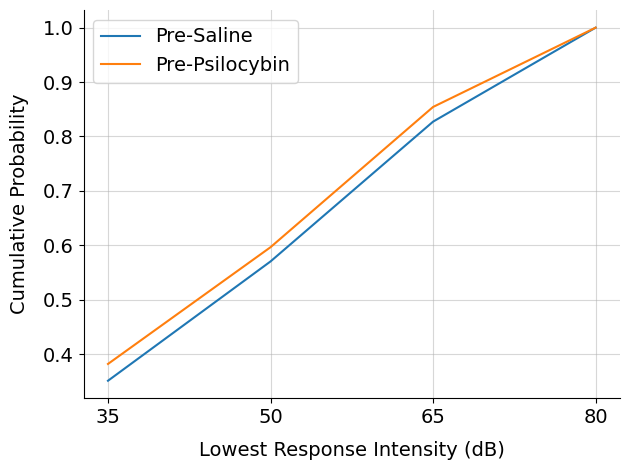

In [13]:
title = ''
label_1 = 'Pre-Saline'
label_2 = 'Pre-Psilocybin'
plot_cdf(sensitivity_pre_saline,sensitivity_pre_psilo,title,label_1,label_2)

In [36]:
from scipy.stats import mannwhitneyu

statistic, p_value = mannwhitneyu(sensitivity_post_saline, sensitivity_post_psilo)

print(f"Mann-Whitney U statistic: {statistic}")
print(f"P-value: {p_value}")

Mann-Whitney U statistic: 316619.5
P-value: 4.119937670478548e-05


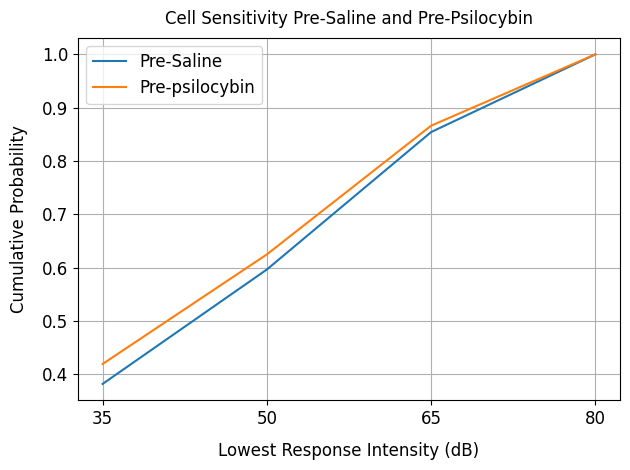

In [15]:
title = 'Cell Sensitivity Pre-Saline and Pre-Psilocybin'
label_1 = 'Pre-Saline'
label_2 = 'Pre-psilocybin'
plot_cdf(sensitivity_pre_psilo,sensitivity_post_psilo,title,label_1,label_2)

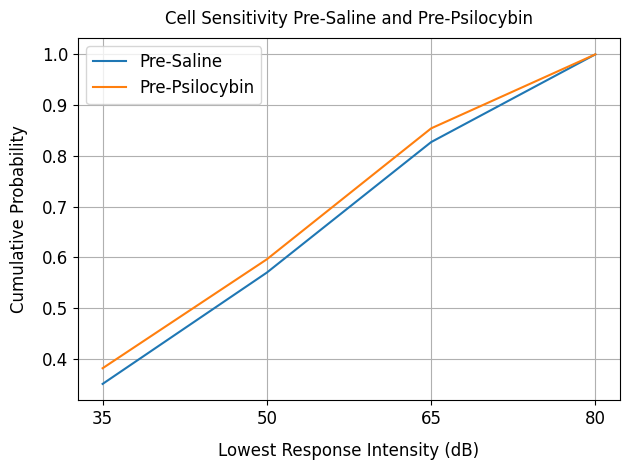

In [16]:
title = 'Cell Sensitivity Pre-Saline and Pre-Psilocybin'
label_1 = 'Pre-Saline'
label_2 = 'Pre-Psilocybin'
plot_cdf(sensitivity_pre_saline,sensitivity_pre_psilo,title,label_1,label_2)

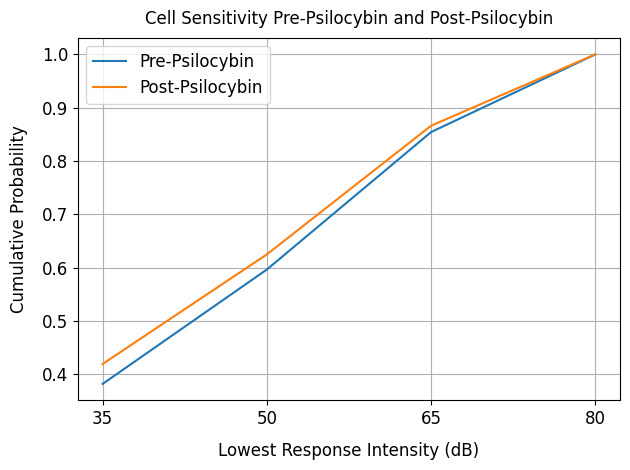

In [17]:
title = 'Cell Sensitivity Pre-Psilocybin and Post-Psilocybin'
label_1 = 'Pre-Psilocybin'
label_2 = 'Post-Psilocybin'
plot_cdf(sensitivity_pre_psilo,sensitivity_post_psilo,title,label_1,label_2)

In [18]:
from scipy.stats import mannwhitneyu

statistic, p_value = mannwhitneyu(sensitivity_post_saline, sensitivity_post_psilo)

print(f"Mann-Whitney U statistic: {statistic}")
print(f"P-value: {p_value}")

Mann-Whitney U statistic: 316619.5
P-value: 4.119937670478548e-05


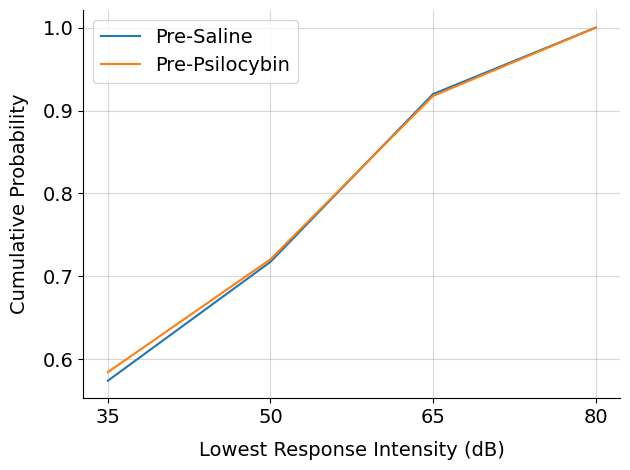

In [14]:
lowest_saline = get_lowest_response_intensity_matched(saline_pre,saline_post)
lowest_psilo = get_lowest_response_intensity_matched(psilo_pre,psilo_post)

title = ''
label_1 = 'Pre-Saline'
label_2 = 'Pre-Psilocybin'
plot_cdf(lowest_saline[:,0],lowest_psilo[:,0],title,label_1,label_2)

In [38]:
print(lowest_saline.shape)

(237, 2)


In [74]:
import numpy as np
from scipy.stats import wilcoxon

# Perform Wilcoxon signed-rank test
statistic, p_value = wilcoxon(lowest_saline[:,0], lowest_saline[:,1])

# Output the results
print(f"Wilcoxon signed-rank statistic: {statistic}")
print(f"P-value: {p_value}")

Wilcoxon signed-rank statistic: 1800.0
P-value: 0.31068097011101425


In [70]:
from scipy.stats import mannwhitneyu

statistic, p_value = mannwhitneyu(lowest_psilo[:,0], lowest_psilo[:,1])

print(f"Mann-Whitney U statistic: {statistic}")
print(f"P-value: {p_value}")

Mann-Whitney U statistic: 40923.0
P-value: 0.22841927907212278


In [ ]:
#look at changes in tuning specifically for the non-coactive cells

In [77]:
def get_counts(BF_list):
    counts = Counter(BF_list)
    keys = list(counts.keys())
    keys = sorted(keys)
    counts_sorted = {i: counts[i] for i in keys}
    counts_sorted_density = {k: v / len(BF_list) for k, v in counts_sorted.items()}

    return counts_sorted_density

In [78]:
# Change in Lowest Response Intensity:

shift_lowest_response_saline = lowest_saline[:,1] - lowest_saline[:,0]
shift_lowest_response_psilo = lowest_psilo[:,1] - lowest_psilo[:,0]

# Values to be removed
values_to_remove = {-3, 3}

# Create a new list without the specified values
shift_lowest_response_saline = [x for x in shift_lowest_response_saline if x not in values_to_remove]
shift_lowest_response_psilo = [x for x in shift_lowest_response_psilo if x not in values_to_remove]

# Change to counts dict:

counts_shift_lowest_response_saline = get_counts(shift_lowest_response_saline)
counts_shift_lowest_response_psilo = get_counts(shift_lowest_response_psilo)

print(counts_shift_lowest_response_psilo)






{-2: 0.06439393939393939, -1: 0.10606060606060606, 0: 0.7159090909090909, 1: 0.07196969696969698, 2: 0.041666666666666664}


In [16]:
def plot_counts(pre_dict,post_dict,label_pre,label_post):
    x = pre_dict.keys()

    y1 = list(pre_dict.values())
    y2 = list(post_dict.values())

    n=5
    r = np.arange(n)
    width = 0.25
    labels = ['-20','-10','0','+10','+20']

    plt.bar(r, y1, color = 'b', 
        width = width, edgecolor = 'black', 
        label=label_pre) 
    plt.bar(r + width, y2, color = 'orange', 
        width = width, edgecolor = 'black', 
        label=label_post) 
  

    plt.xticks(r + width/2,labels,rotation=45) 

    plt.ylabel("Probability")
    plt.xlabel("Shift in Lowest Response Intensity (dB)")
    plt.title("Shift in Lowest Intensity of Sound Response, Matched Cells",pad=10)

    plt.legend() 
    plt.tight_layout  
    plt.show() 

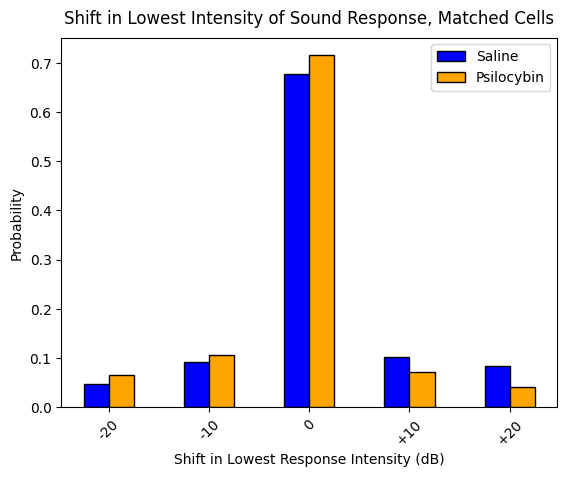

In [24]:
plot_counts(counts_shift_lowest_response_saline,counts_shift_lowest_response_psilo,'Saline','Psilocybin')

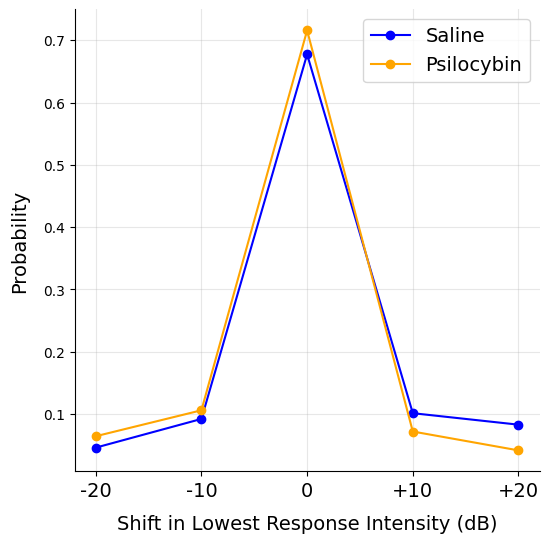

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming the functions calculate_relative_frequencies and the data psilo_pre_bandwidth_65 and psilo_post_bandwidth_65 are defined

# # Calculate unique values for each set
# unique_values_set1 = np.unique(psilo_pre_bandwidth_65)
# unique_values_set2 = np.unique(psilo_post_bandwidth_65)

# # Combine unique values from both sets
# unique_values = np.unique(np.concatenate((unique_values_set1, unique_values_set2)))

# # Halve the unique values except for 0
# halved_unique_values = [value / 2 if value != 0 else 0 for value in unique_values]

# # Calculate relative frequencies for each set based on the unique values
# rel_freq_set1 = calculate_relative_frequencies(psilo_pre_bandwidth_65, unique_values)
# rel_freq_set2 = calculate_relative_frequencies(psilo_post_bandwidth_65, unique_values)

y1 = list(counts_shift_lowest_response_saline.values())
y2 = list(counts_shift_lowest_response_psilo.values())


# Your first set of probability data
data1 = y1

# Your second set of probability data
data2 = y2

# Generate x values corresponding to the data points
x1 = np.arange(len(data1))
x2 = np.arange(len(data2))

# Plotting
plt.figure(figsize=(6, 6))

# Plot the first set of data
plt.plot(x1, data1, marker='o', linestyle='-', color='b', label='Saline')

# Plot the second set of data
plt.plot(x2, data2, marker='o', linestyle='-', color='orange', label='Psilocybin')

# Customize x-tick labels if needed
bandwidth_categories = ['-20','-10','0','+10','+20']
plt.xticks(ticks=np.arange(len(data1)), labels=bandwidth_categories,fontsize=14)

# Add labels and title
plt.xlabel('Shift in Lowest Response Intensity (dB)',fontsize=14,labelpad=10)
plt.ylabel('Probability',fontsize=14,labelpad=10)
plt.grid(True, alpha=0.3)  # Adjust the alpha value for transparency

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# Add a legend
plt.legend(fontsize=14)

# Show plot
plt.grid(True)
plt.show()

In [79]:
from scipy.stats import mannwhitneyu

statistic, p_value = mannwhitneyu(shift_lowest_response_saline, shift_lowest_response_psilo)

print(f"Mann-Whitney U statistic: {statistic}")
print(f"P-value: {p_value}")

Mann-Whitney U statistic: 31221.5
P-value: 0.0361107793606402


In [59]:
# Perform KS test between two samples
ks_statistic, p_value = ss.kstest(shift_lowest_response_saline, shift_lowest_response_psilo)

# Print test results
print("KS Statistic:", ks_statistic)
print("P-value:", p_value)

KS Statistic: 0.07835397667982397
P-value: 0.384919977893173


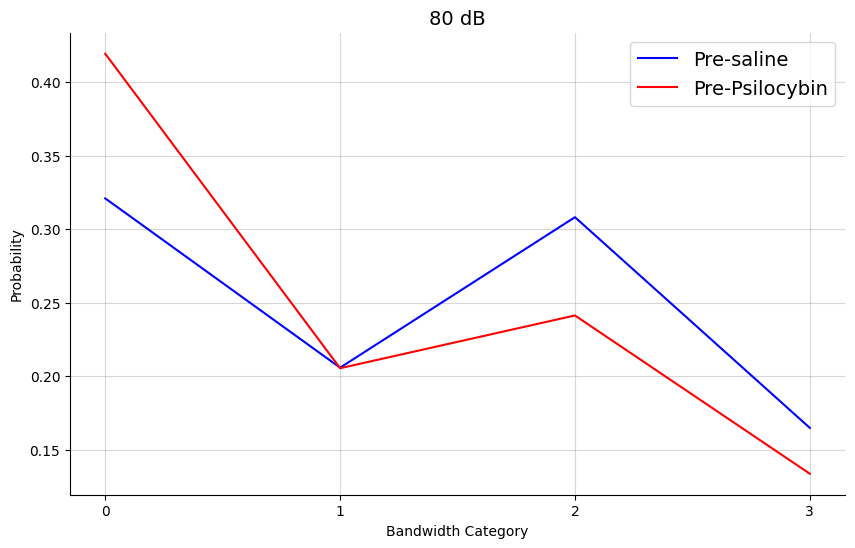

In [21]:
import matplotlib.pyplot as plt
import numpy as np


data1 = sensitivity_post_saline
data2 = sensitivity_post_psilo
title = "80 dB"

# Calculate unique values for each set
unique_values_set1 = np.unique(data1)
unique_values_set2 = np.unique(data2)


# Combine unique values from both sets
unique_values = np.unique(np.concatenate((unique_values_set1, unique_values_set2)))

# Calculate relative frequencies for each set based on the unique values
rel_freq_set1 = calculate_relative_frequencies(data1, unique_values)
rel_freq_set2 = calculate_relative_frequencies(data2, unique_values)

# Your first set of probability data
data1 = rel_freq_set1

# Your second set of probability data
data2 = rel_freq_set2

# Generate x values corresponding to the data points
x1 = np.arange(len(data1))
x2 = np.arange(len(data2))

# Plotting
plt.figure(figsize=(10, 6))


# Plot the first set of data
plt.plot(x1, data1, linestyle='-', color='b', label='Pre-saline')

# Plot the second set of data
plt.plot(x2, data2, linestyle='-', color='r', label='Pre-Psilocybin')

# Customize x-tick labels if needed
bandwidth_categories = np.arange(len(data1))  # Example categories based on the length of data1
plt.xticks(ticks=np.arange(len(data1)), labels=bandwidth_categories)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add labels and title
plt.xlabel('Bandwidth Category')
plt.ylabel('Probability')
plt.title(title,fontsize=14)

# Add a legend
plt.legend(fontsize=14)

# Show plot
plt.grid(True,alpha=0.5)
plt.show()

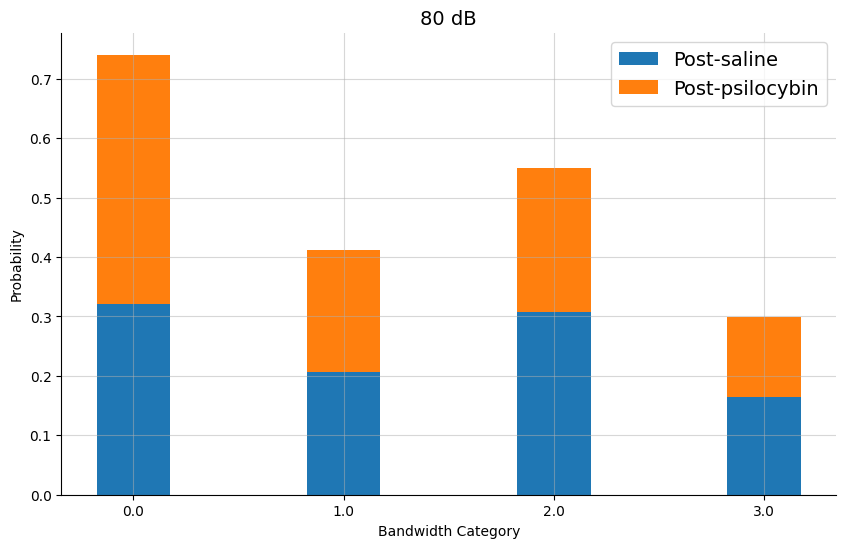

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Function to calculate relative frequencies
def calculate_relative_frequencies(data, unique_values):
    counts = np.array([np.sum(data == uv) for uv in unique_values])
    rel_freq = counts / counts.sum()
    return rel_freq

title = "80 dB"

# Calculate unique values for each set
unique_values_set1 = np.unique(sensitivity_post_saline)
unique_values_set2 = np.unique(sensitivity_post_psilo)

# Combine unique values from both sets
unique_values = np.unique(np.concatenate((unique_values_set1, unique_values_set2)))

# Calculate relative frequencies for each set based on the unique values
rel_freq_set1 = calculate_relative_frequencies(sensitivity_post_saline, unique_values)
rel_freq_set2 = calculate_relative_frequencies(sensitivity_post_psilo, unique_values)

# Plotting
plt.figure(figsize=(10, 6))

# Plot the stacked histogram
width = 0.35
plt.bar(unique_values, rel_freq_set1, width, label='Post-saline')
plt.bar(unique_values, rel_freq_set2, width, bottom=rel_freq_set1, label='Post-psilocybin')

# Customize x-tick labels if needed
plt.xticks(ticks=unique_values, labels=unique_values)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add labels and title
plt.xlabel('Bandwidth Category')
plt.ylabel('Probability')
plt.title(title, fontsize=14)

# Add a legend
plt.legend(fontsize=14)

# Show plot
plt.grid(True, alpha=0.5)
plt.show()

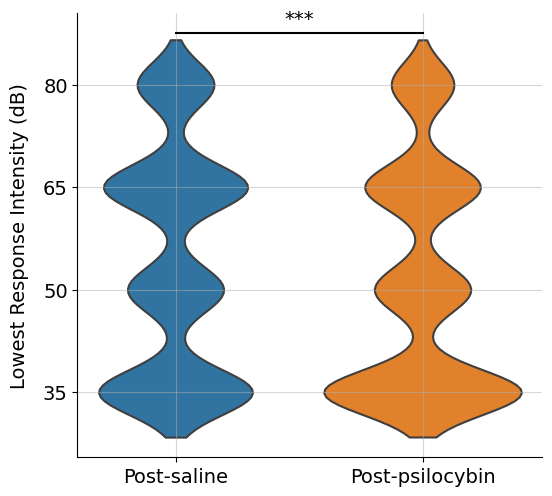

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


title = "80 dB"

# Normalize the data to relative frequencies for categorical data
def normalize_data(data, categories):
    counts = np.array([np.sum(data == category) for category in categories])
    relative_freqs = counts / counts.sum()
    normalized_data = np.repeat(categories, (relative_freqs * 100).astype(int))
    return normalized_data

categories = np.array([0, 1, 2, 3])
normalized_saline = normalize_data(sensitivity_post_saline, categories)
normalized_psilo = normalize_data(sensitivity_post_psilo, categories)

# Combine the data into a single DataFrame for easier plotting with seaborn
data = pd.DataFrame({
    'Sensitivity': np.concatenate((normalized_saline, normalized_psilo)),
    'Condition': ['Post-saline'] * len(normalized_saline) + ['Post-psilocybin'] * len(normalized_psilo)
})

# Define the custom palette using Matplotlib's default colors
custom_palette = {
    'Post-saline': '#1f77b4',  # Matplotlib blue
    'Post-psilocybin': '#ff7f0e'  # Matplotlib orange
}

# Plotting
plt.figure(figsize=(6, 6))

# Create violin plot with specified colors
sns.violinplot(x='Condition', y='Sensitivity', data=data, palette=custom_palette, bw=0.2, inner=None)

# Customize the plot
plt.ylabel('Lowest Response Intensity (dB)', labelpad=10,fontsize=14)
plt.yticks(categories, ['35', '50', '65', '80'],fontsize=14)  # Set the y-ticks to the specific categories
plt.xticks(fontsize=14)
plt.xlabel("")
plt.grid(True, alpha=0.5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add horizontal line and significance asterisks
y_line = max(categories) + 0.5  # Set the y position of the line
plt.plot([0, 1], [y_line, y_line], color='black', lw=1.5)
plt.text(0.5, y_line + 0.05, '***', ha='center', va='bottom', color='black', fontsize=14)

# Adjust the subplot parameters to add white space
plt.subplots_adjust(top=0.85)

# Show plot
plt.show()

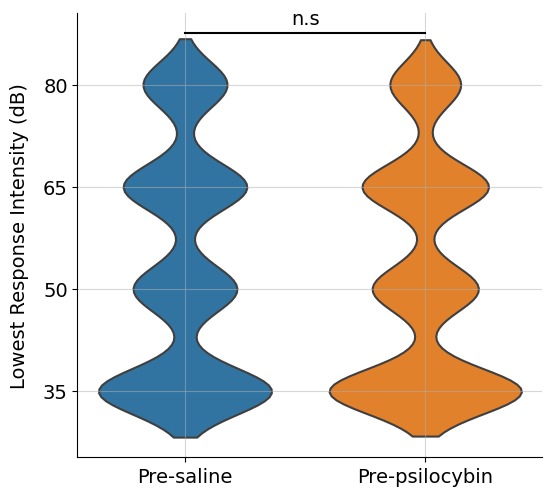

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


title = "80 dB"

# Normalize the data to relative frequencies for categorical data
def normalize_data(data, categories):
    counts = np.array([np.sum(data == category) for category in categories])
    relative_freqs = counts / counts.sum()
    normalized_data = np.repeat(categories, (relative_freqs * 100).astype(int))
    return normalized_data

categories = np.array([0, 1, 2, 3])
normalized_saline = normalize_data(sensitivity_pre_saline, categories)
normalized_psilo = normalize_data(sensitivity_pre_psilo, categories)

# Combine the data into a single DataFrame for easier plotting with seaborn
data = pd.DataFrame({
    'Sensitivity': np.concatenate((normalized_saline, normalized_psilo)),
    'Condition': ['Pre-saline'] * len(normalized_saline) + ['Pre-psilocybin'] * len(normalized_psilo)
})

# Define the custom palette using Matplotlib's default colors
custom_palette = {
    'Pre-saline': '#1f77b4',  # Matplotlib blue
    'Pre-psilocybin': '#ff7f0e'  # Matplotlib orange
}

# Plotting
plt.figure(figsize=(6, 6))

# Create violin plot with specified colors
sns.violinplot(x='Condition', y='Sensitivity', data=data, palette=custom_palette, bw=0.2, inner=None)

# Customize the plot
plt.ylabel('Lowest Response Intensity (dB)', labelpad=10,fontsize=14)
plt.yticks(categories, ['35', '50', '65', '80'],fontsize=14)  # Set the y-ticks to the specific categories
plt.xticks(fontsize=14)
plt.xlabel("")
plt.grid(True, alpha=0.5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add horizontal line and significance asterisks
y_line = max(categories) + 0.5  # Set the y position of the line
plt.plot([0, 1], [y_line, y_line], color='black', lw=1.5)
plt.text(0.5, y_line + 0.05, 'n.s', ha='center', va='bottom', color='black', fontsize=14)

# Adjust the subplot parameters to add white space
plt.subplots_adjust(top=0.85)

# Show plot
plt.show()